In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

In [2]:
files = [   
            # orig
            # ["growth_data/cyrus_blue_020824.txt",
            #   {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "Zn", "H": "B12"},
            #   [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
            #   [["A", "B", "C", "D"], ["E", "F", "G", "H"]],
            #   {"YkgM1": [0, 0], "MG1655": [1, 0]},
            #  12],

            # # good?
             # ["growth_data/cyrus_pink_020924.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],

             # # p bad
             # ["growth_data/cyrus_blue_021324.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],


             # # also p bad
             # ["growth_data/cyrus_blue_021424.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],

             # ["growth_data/cyrus_blue_021524.txt",
             # {"A": "met", "B": "met", "C": "none", "D": "B12", "E": "Zn","F": "met+B12", "G": "met+Zn", "H": "met+B12+Zn"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],

                #200 µM paraquat
             # ["growth_data/cyrus_031524_paraquat_Mn.txt", 
             # {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
             #  "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             # ["growth_data/cyrus_031524_paraquat_Mn_part2.txt",
             # {"A": "Mn 0", "B": "Mn 1", "C": "Mn 2", "D": "Mn 3", "E": "Mn 4","F": "Mn 5", "G": "Mn 6", "H": "Mn 7"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             # ["growth_data/cyrus_032024_paraquat_Mn.txt", 2 µM paraquat
             # {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
             #  "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             # 20 µM paraquat

             # ["growth_data/cyrus_Mn_032724.txt",
             # {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
             #  "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             #     # also p bad
             # ["growth_data/NO3_Mo_full_plate_053124.txt",
             # {"A": "-/-", "B": "+/-", "C": "-/1", "D": "-/2","E": "-/3", "F": "+/1", "G": "+/2", "H": "+/3"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],

             #  # control, either -/+ nitrate and mo
             # ["growth_data/ezRich_NO3_test_060424.txt",
             # {"A": "-", "B": "-", "C": "-", "D": "-","E": "+", "F": "+", "G": "+", "H": "+"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],

              # control, either -/+ nitrate and mo. good data. 
             # ["growth_data/ezRich_NO3_test_060524.txt",
             # {"A": "-/-", "B": "-/-", "C": "-/2", "D": "+/3","E": "+/2", "F": "+/1", "G": "+/-", "H": "+/-"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],
             
             # ["growth_data/CuMn_gradient_061324.txt",
             # {"A": "-/-", "B": "-/-", "C": "-/2", "D": "+/3","E": "+/2", "F": "+/1", "G": "+/-", "H": "+/-"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],

             # ["growth_data/ZnMn_gradient_061324.txt",
             # {"A": "-/-", "B": "-/-", "C": "-/2", "D": "+/3","E": "+/2", "F": "+/1", "G": "+/-", "H": "+/-"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],

             # ["growth_data/aerobics_metals_070424.txt",
             # {"1": "1/1/-", "2": "1/2/-", "3": "1/3/-", "4": "2/1/-",
             #  "5": "2/2/-", "6": "2/3/-", "7": "3/1/-", "8": "3/2/-", 
             #  "9": "3/3/-", "10": "2/2/+", "11": "2/2/+", "12": "2/2/+"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  8],

             #     ["growth_data/aerobic_metals_071124.txt",
             # {"1": "1/1", "2": "1/1", "3": "1/1", "4": "1/1",
             #  "5": "2/2", "6": "2/2", "7": "2/2", "8": "2/2", 
             #  "9": "3/3", "10": "3/3", "11": "3/3", "12": "3/3"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  8],

             #     ["growth_data/082224_aerobic_EzLbTsb.txt",
             # {"A": "EZ", "B": "EZ + Mn, Zn", "C": "EZ + GSH", "D": "EZ+Mn,Zn,GSH","E": "LB", "F": "LB+Mn,Zn,GSH", "G": "TSB", "H": "TSB+Mn,Zn,GSH"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],


             # ["growth_data/082624_cyrus_M9_LB_TSB.txt",
             # {"A": "EZ", "B": "EZ + Mn, Zn", "C": "EZ + GSH", "D": "EZ+Mn,Zn,GSH","E": "LB", "F": "LB+Mn,Zn,GSH", "G": "TSB", "H": "TSB+Mn,Zn,GSH"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655": [0, 0]},
             #  12],

            ["growth_data/anaerobic_082924.txt",
             {"A": "Base", "B": "No NO3, Mo 2", "C": "NO3, Mo 1", "D": "NO3, Mo 2","E": "NO3, Mo 3", "F": "NO3, No Mo", "G": "TSB+MO", "H": "TSB+NO3 Mo"},
             [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G", "H"]],
             {"MG1655": [0, 0]},
              12],
    
        ]




for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    if "A" in additive.keys():
        al = al.rename({"column": "Row", "column_0": "Additive"})
    if "1" in additive.keys():
        al = al.rename({"column": "Column", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,…,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,Plate,N_replicate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32
0.004444,0.094,0.0919,0.0804,0.0834,0.0828,0.0876,0.0873,0.0921,0.0912,0.0854,0.0907,0.0873,0.0853,0.2769,0.0875,0.09,0.086,0.083,0.0946,0.1535,0.0852,0.0909,0.0876,0.088,0.0852,0.0864,0.0821,0.0887,0.0925,0.0938,0.0822,0.1043,0.0957,0.1108,0.0876,0.0839,…,0.0931,0.085,0.0871,0.0937,0.0863,0.1022,0.095,0.0945,0.0867,0.1473,0.0856,0.0911,0.093,0.0911,0.0921,0.1072,0.0897,0.0907,0.0956,0.0909,0.1552,0.0915,0.0953,0.0913,0.0898,0.1202,0.094,0.0938,0.0914,0.0905,0.0914,0.091,0.0911,0.0925,0.092,"""Plate 1""",12
0.021111,0.0938,0.0914,0.0805,0.0832,0.0827,0.0873,0.0891,0.1132,0.0885,0.0855,0.0899,0.0871,0.085,0.2794,0.0862,0.0898,0.0858,0.0828,0.0916,0.1462,0.0851,0.091,0.0877,0.0885,0.0849,0.0861,0.082,0.0889,0.0926,0.0943,0.0829,0.1067,0.0951,0.1022,0.0874,0.0839,…,0.0929,0.0849,0.0869,0.0986,0.0864,0.0986,0.0942,0.0944,0.0866,0.1051,0.0855,0.0913,0.0931,0.0915,0.0921,0.1075,0.0896,0.091,0.0954,0.0905,0.1367,0.0916,0.0952,0.0916,0.0897,0.1228,0.094,0.0942,0.0914,0.0908,0.0913,0.0907,0.0906,0.0926,0.092,"""Plate 1""",12
0.037778,0.0936,0.0914,0.0804,0.0834,0.0823,0.0872,0.0883,0.0965,0.0938,0.0854,0.0901,0.0872,0.0844,0.2811,0.0857,0.0896,0.0857,0.083,0.094,0.1537,0.085,0.0912,0.0878,0.0889,0.0849,0.0861,0.0821,0.0892,0.0928,0.0948,0.0853,0.1068,0.0948,0.095,0.0873,0.0838,…,0.0929,0.0852,0.0875,0.1062,0.0865,0.098,0.0941,0.0945,0.0867,0.1008,0.0858,0.0913,0.0933,0.0915,0.0921,0.1072,0.0896,0.0913,0.0953,0.0906,0.1314,0.0918,0.0951,0.0924,0.0897,0.1238,0.0939,0.0947,0.0913,0.0908,0.091,0.0907,0.0905,0.0929,0.0921,"""Plate 1""",12


In [3]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

if "A" in additive.keys():
    mdf = mdf.join(adf, on=["Plate", "Row"])
elif "1" in additive.keys():
    mdf = mdf.join(adf, on=["Plate", "Column"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

if "A" in additive.keys():
    mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))
elif "1" in additive.keys():
    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}
    mdf = mdf.with_columns(Row=pl.col("Row").replace(mapping))
    mdf = mdf.with_columns(   ((pl.col("Row").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
# mdf = mdf.filter(pl.col("Genotype") == "MG1655")

mdf.head()

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32
0.004444,"""Plate 1""",12,"""A1""",0.094,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1
0.021111,"""Plate 1""",12,"""A1""",0.0938,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1
0.037778,"""Plate 1""",12,"""A1""",0.0936,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1
0.054444,"""Plate 1""",12,"""A1""",0.0935,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1
0.071111,"""Plate 1""",12,"""A1""",0.0938,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1


In [4]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate,Initial_corrected_OD,Initial_median_corrected_OD
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32,f64,f64
0.004444,"""Plate 1""",12,"""A1""",0.094,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1,0.0055,0.0048
0.021111,"""Plate 1""",12,"""A1""",0.0938,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1,0.0053,0.0046
0.037778,"""Plate 1""",12,"""A1""",0.0936,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1,0.0051,0.0044
0.054444,"""Plate 1""",12,"""A1""",0.0935,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1,0.005,0.0043
0.071111,"""Plate 1""",12,"""A1""",0.0938,"""A""","""1""","""Base""","""MG1655""",0.0885,0.0892,1,0.0053,0.0046


(0.0, 1.0)

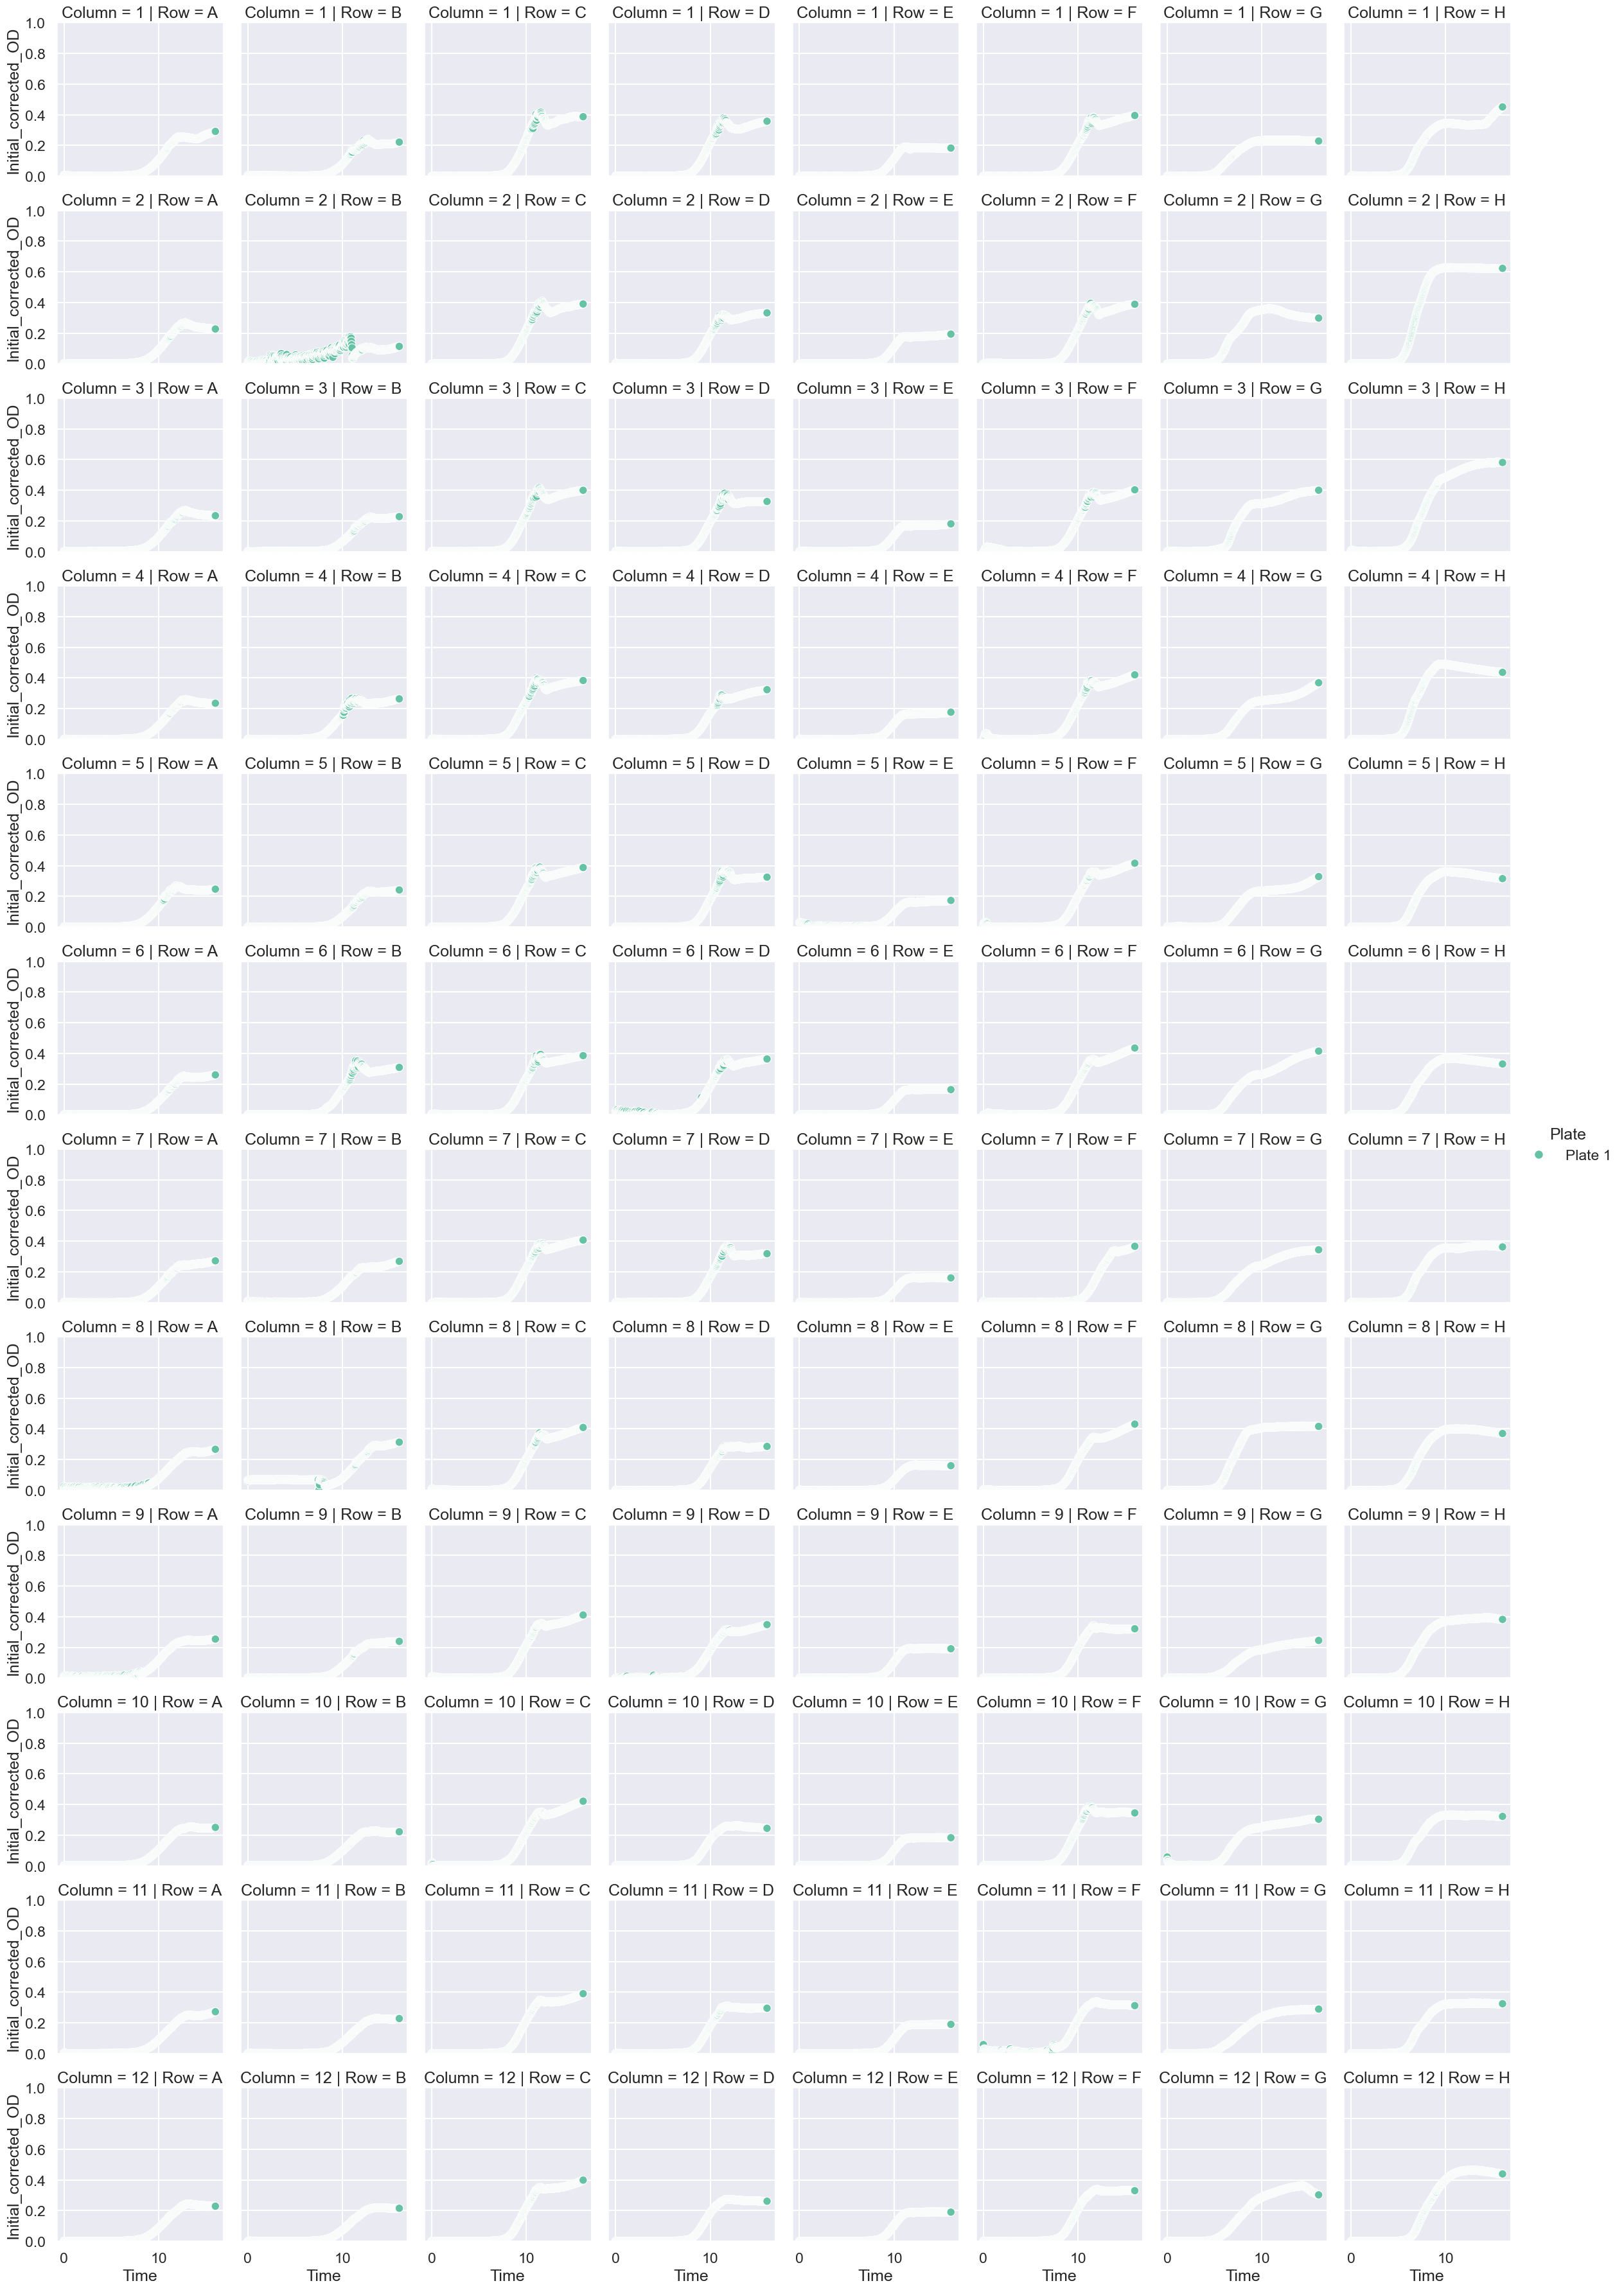

In [5]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

plt.ylim(0,1)

In [6]:
f_mdf = mdf.filter(pl.col("Time") > 1).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_median_corrected_OD")).log())
    .alias("Log_initial_median_corrected_OD")
])


f_mdf = f_mdf.filter(pl.col("Log_initial_corrected_OD").is_not_nan())

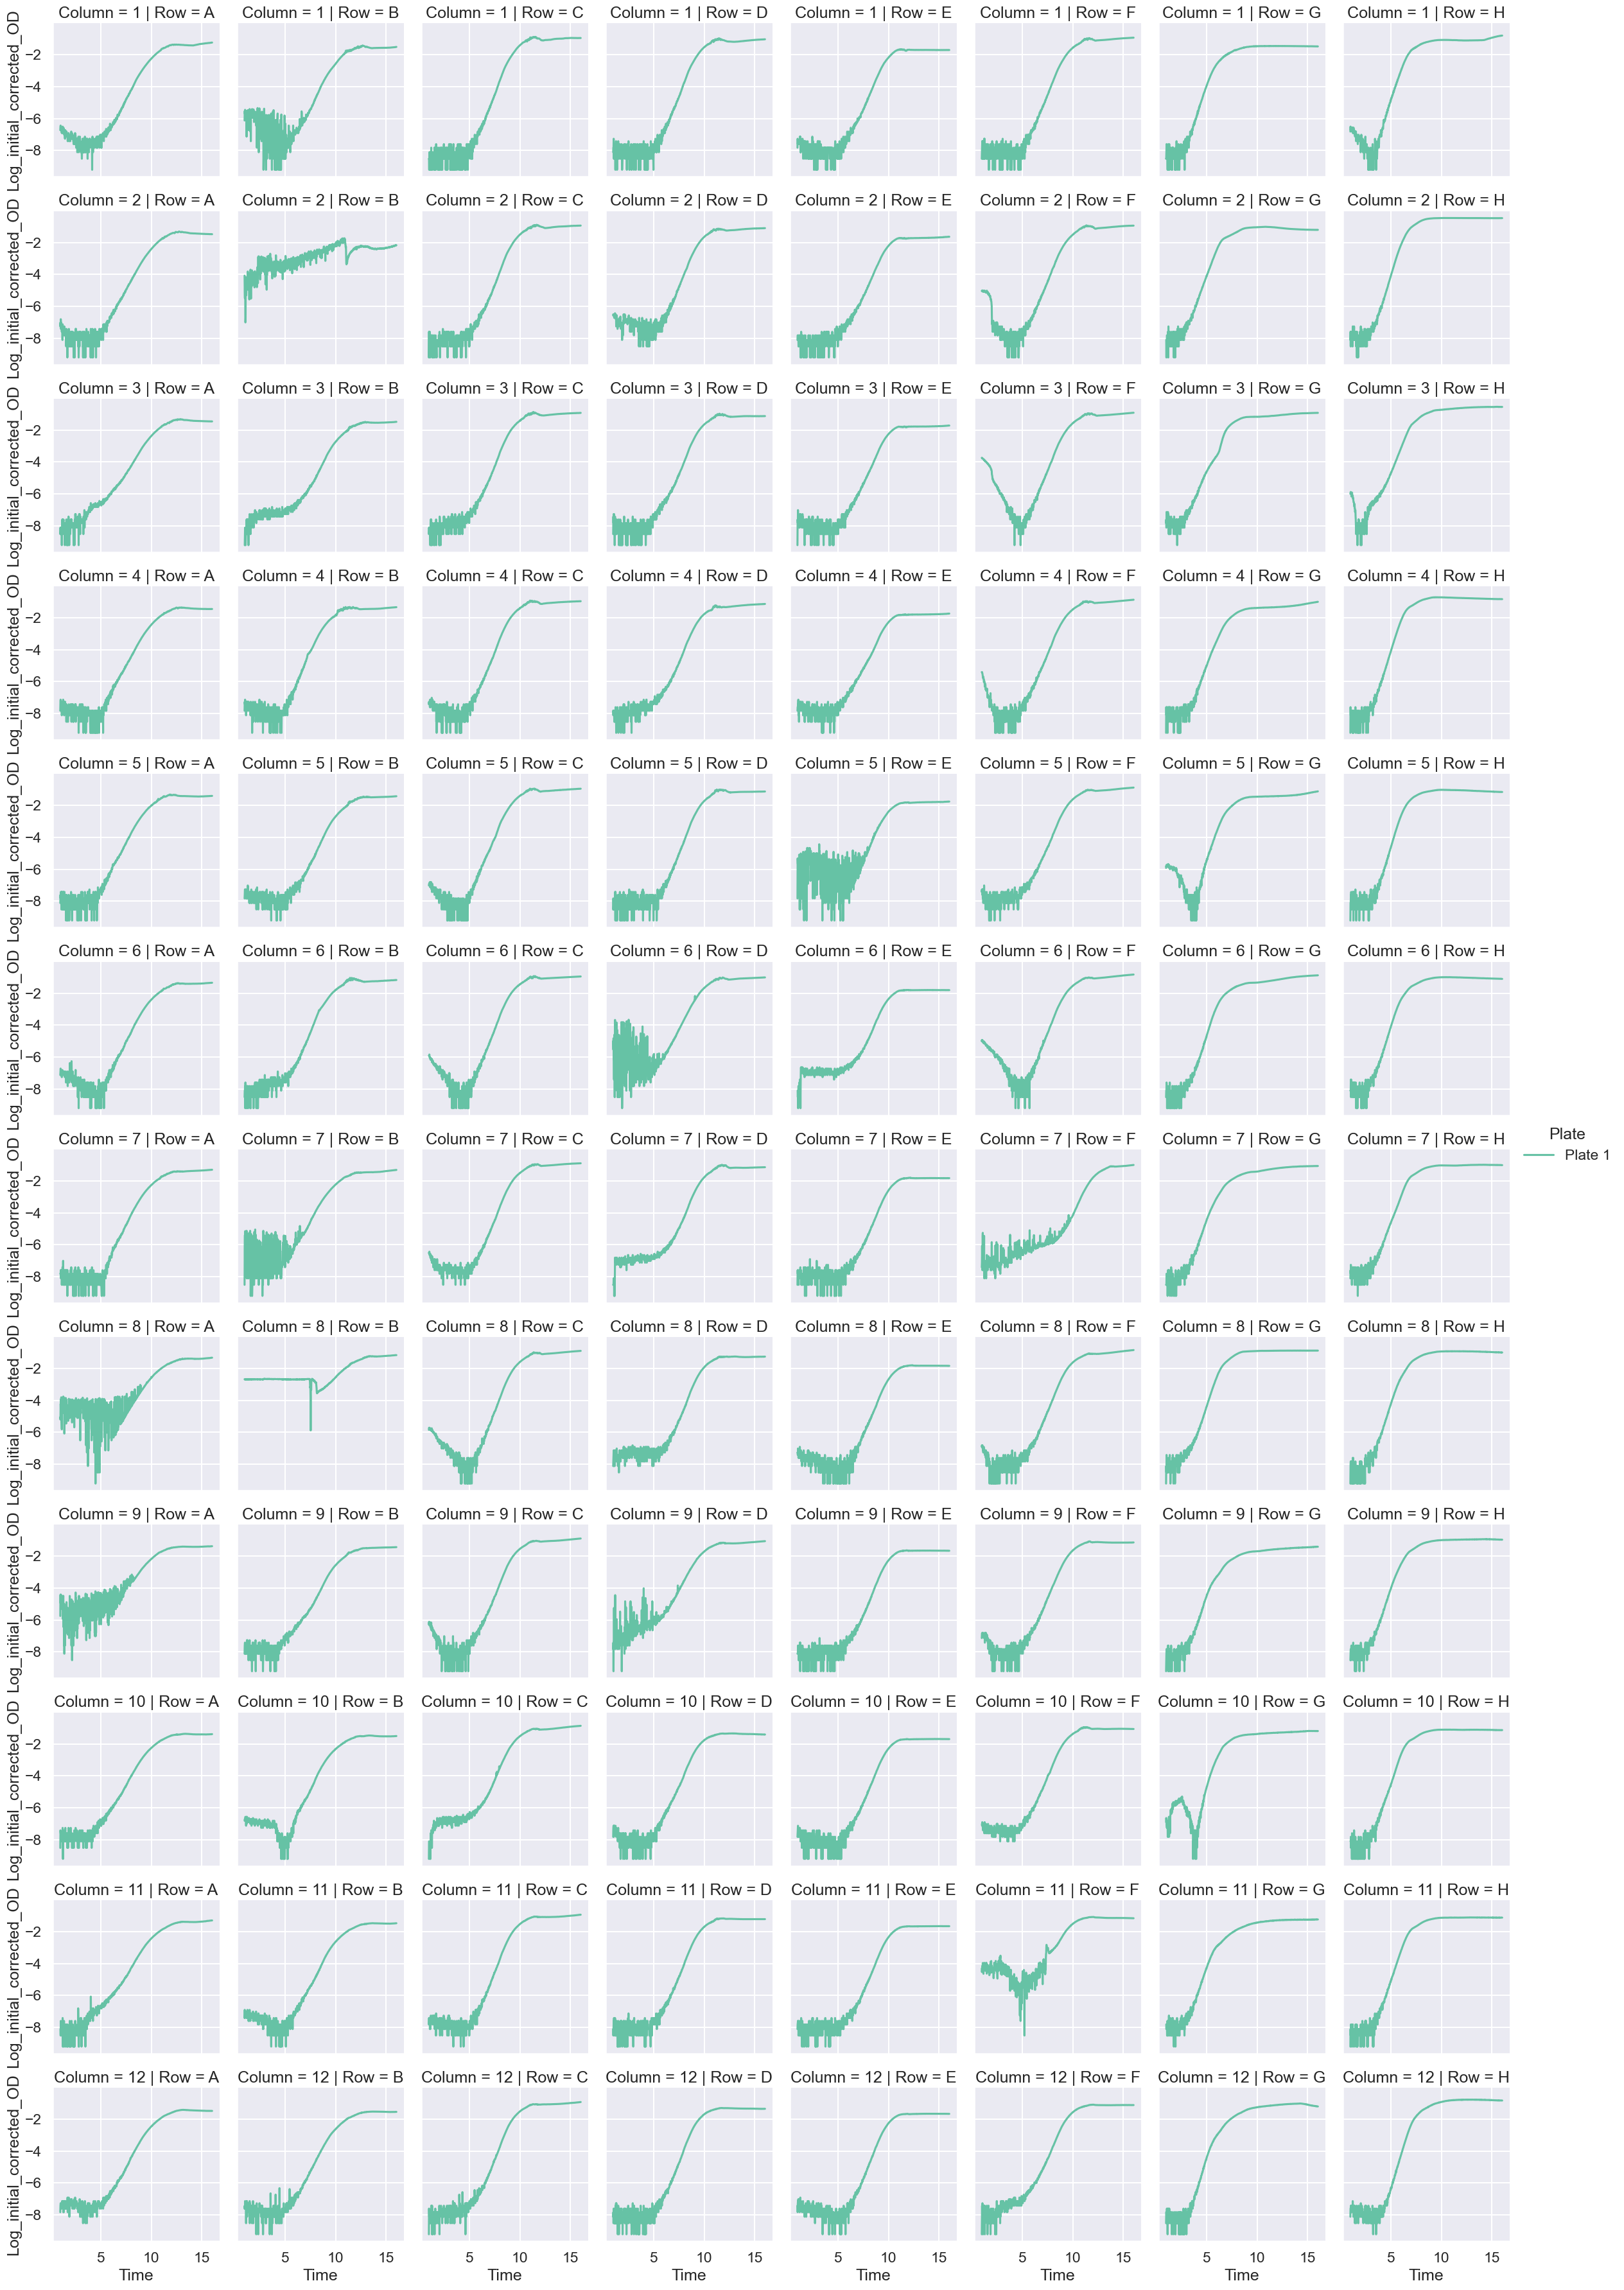

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))


In [8]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -5.5).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -3).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

M = 0
N = 3
top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_28933/2521229149.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


(5.0, 10.0)

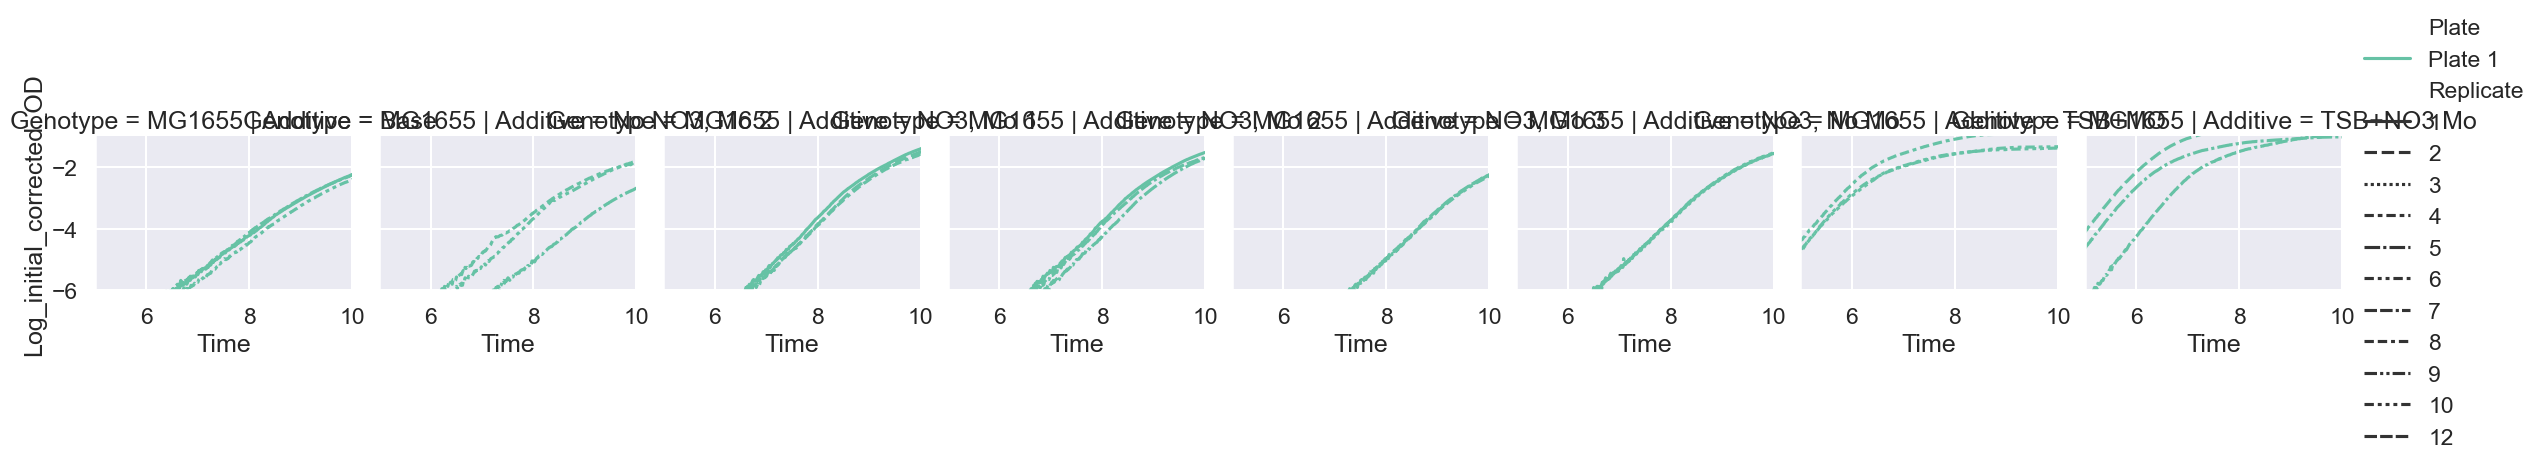

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Genotype", col="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

plt.ylim(-6,-1)
plt.xlim(5,10)
    
# plt.savefig("weird_plate.png")

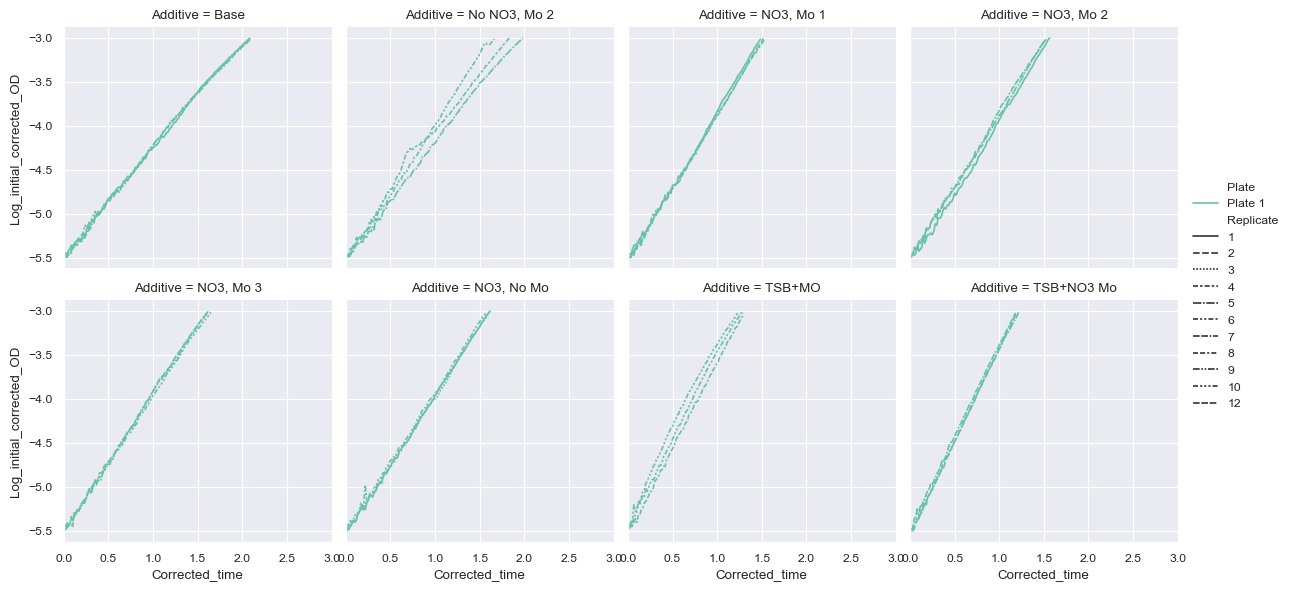

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,3])

# plt.savefig("plates.png")

(0.0, 3.0)

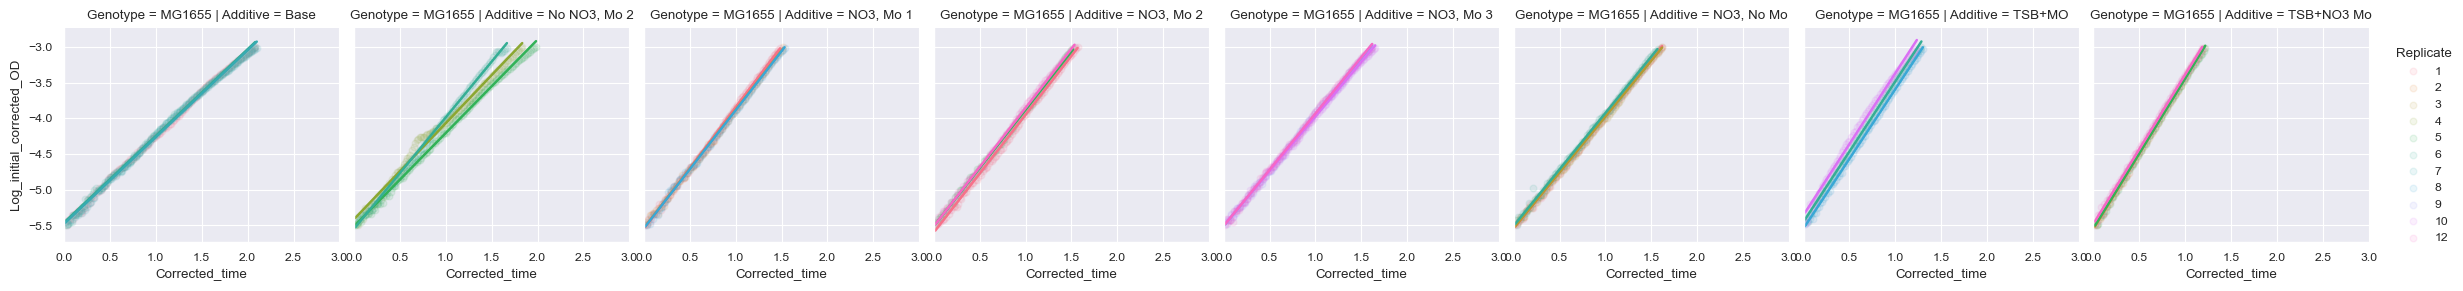

In [11]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [12]:
# sns.relplot(x="Time", y="Log_initial_corrected_OD", kind="line", row="Replicate", col="Additive", height=3, \
#             data=f_mdf.filter(pl.col("Time") < 15))

In [13]:
# sns.set_context("paper")

# sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", \
#             # row="Genotype", height=3, \
#             col_wrap=4,
#             data=mdf)

In [14]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"] * 60
predicted_gr

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_28933/4127042248.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


,Genotype,Additive,Replicate,Plate,slope,intercept,slope_e,intercept_e,doubling_time
0,MG1655,Base,1,Plate 1,1.215563,-5.473509,0.004035,0.004883,34.213630
1,MG1655,Base,6,Plate 1,1.213204,-5.461190,0.005071,0.006136,34.280166
2,MG1655,Base,7,Plate 1,1.215814,-5.481237,0.005438,0.006632,34.206562
3,MG1655,"NO3, Mo 1",1,Plate 1,1.705951,-5.553032,0.005614,0.004849,24.378672
4,MG1655,"NO3, Mo 1",2,Plate 1,1.657083,-5.537288,0.005406,0.004773,25.097617
5,MG1655,"NO3, Mo 1",8,Plate 1,1.653704,-5.542250,0.005222,0.004661,25.148895
6,MG1655,"NO3, Mo 2",1,Plate 1,1.649253,-5.599487,0.007137,0.006507,25.216763
7,MG1655,"NO3, Mo 2",5,Plate 1,1.631299,-5.511924,0.004786,0.004226,25.494309
8,MG1655,"NO3, Mo 2",12,Plate 1,1.657131,-5.513045,0.006146,0.005485,25.096893
9,MG1655,"NO3, Mo 3",9,Plate 1,1.569135,-5.513481,0.004609,0.004335,26.504297


In [15]:
predicted_gr.loc[:, ["Additive", "slope"]].groupby("Additive").mean()

,slope
Additive,
Base,1.214861
"NO3, Mo 1",1.672246
"NO3, Mo 2",1.645894
"NO3, Mo 3",1.557404
"NO3, No Mo",1.575168
"No NO3, Mo 2",1.404758
TSB+MO,1.966077
TSB+NO3 Mo,2.101170


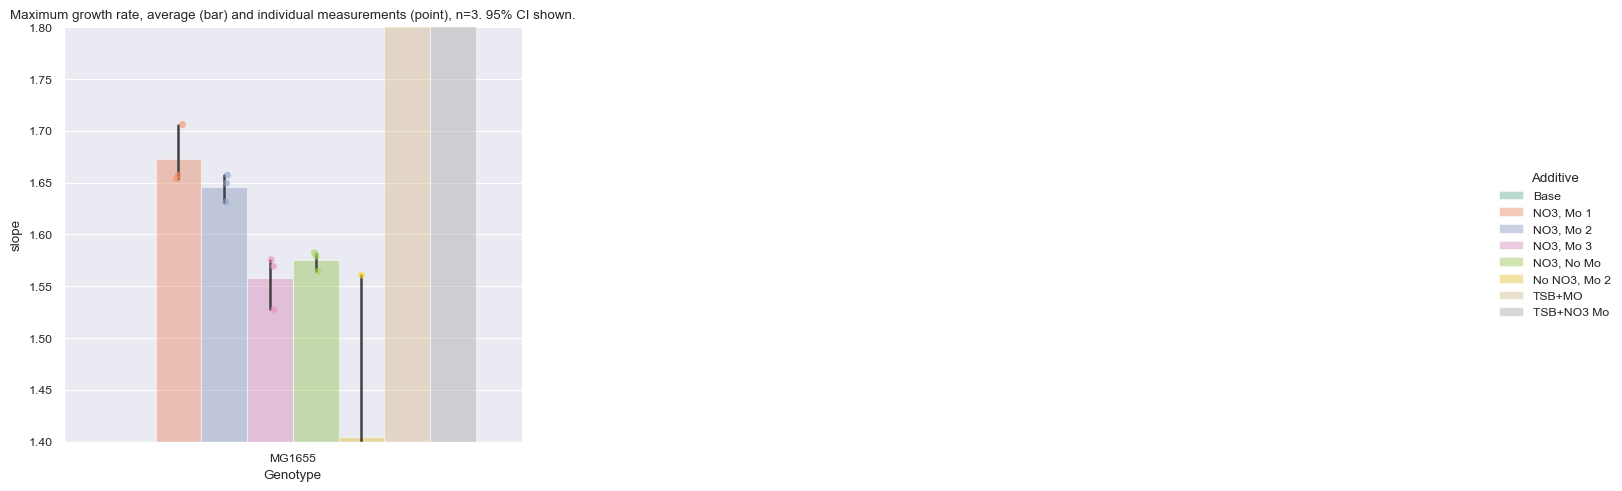

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
    filter_df.head(5)
    
    g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar=('ci', 95),
                    col="Plate", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    plt.ylim([1.4, 1.8])
    
    plt.show()
    
   #  g.savefig("story1.png")

In [17]:
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
    
#     filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
#     filter_df.head(5)
    
#     g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
#                     data=filter_df.to_pandas(), kind="bar", 
#                     height=5, aspect=1, alpha=0.5, hue_order=["none", "Zn", "B12", "met"], errorbar="ci");
#     g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
#                     hue="Additive", palette="Set2",
#                     alpha=0.6, dodge=True, hue_order=["none", "Zn", "B12", "met"])
    
#     plt.title("Minimum doubling time, average (bar) and individual measurements (point), n=3. 95% CI shown.")
#     plt.ylim([1, 1.3])
    
#     plt.show()
    
#    #  g.savefig("story1.png")

# Array based plates